In [23]:
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
import os
import numpy as np
import json

data_type = 'cluster'
root_path = os.path.abspath(f"results/truth/projection-cluster")

meta_path = os.path.join(root_path, 'meta.json')

with open(meta_path, 'r', encoding='utf-8') as f:
    meta = json.loads(f.read())

projections_path = os.path.join(root_path, 'projections')

files = glob(os.path.join(projections_path, '*.csv'))

print("find projectois: ",len(files))
print("methods", meta['methods'])
print("datasets", meta['datasets'])


find projectois:  128
methods ['pca', 'ae', 'cdr', 'oos-mds', 'lmds', 'kmds', 'mimds', 'oos-isomap', 'lisomap', 'kisomap', 'ktsne', 'ptsne', 'ptsne22', 'dlmp-tsne', 'pumap', 'dlmp-umap']
datasets [['cnae9', 1080, 1], ['fashionMNIST', 4200, 1], ['cifar10', 3250, 1], ['imdb', 5000, 1]]


In [24]:
import pandas as pd

projections = {}

for filename in files:
    abspath = os.path.abspath(filename)
    basename = os.path.basename(filename)
    root, ext = os.path.splitext(basename)
    [dataset_name, method_name, stage_idx, batch_name] = root.split('_')
    if dataset_name not in projections:
        projections[dataset_name] = {}
    dataset_stages = projections[dataset_name]
    if stage_idx not in dataset_stages:
        dataset_stages[stage_idx] = {}
    dataset_batch = dataset_stages[stage_idx]
    if batch_name not in dataset_batch:
        dataset_batch[batch_name] = {}
    batch = dataset_batch[batch_name]
    if method_name not in batch:
        batch[method_name] = {}
    batch[method_name] = abspath

print(json.dumps(projections, indent=4))

{
    "cifar10": {
        "0": {
            "test": {
                "ae": "c:\\Users\\60946\\Dev\\OOS-DR-Benchmark\\results\\truth\\projection-cluster\\projections\\cifar10_ae_0_test.csv",
                "cdr": "c:\\Users\\60946\\Dev\\OOS-DR-Benchmark\\results\\truth\\projection-cluster\\projections\\cifar10_cdr_0_test.csv",
                "dlmp-tsne": "c:\\Users\\60946\\Dev\\OOS-DR-Benchmark\\results\\truth\\projection-cluster\\projections\\cifar10_dlmp-tsne_0_test.csv",
                "dlmp-umap": "c:\\Users\\60946\\Dev\\OOS-DR-Benchmark\\results\\truth\\projection-cluster\\projections\\cifar10_dlmp-umap_0_test.csv",
                "kisomap": "c:\\Users\\60946\\Dev\\OOS-DR-Benchmark\\results\\truth\\projection-cluster\\projections\\cifar10_kisomap_0_test.csv",
                "kmds": "c:\\Users\\60946\\Dev\\OOS-DR-Benchmark\\results\\truth\\projection-cluster\\projections\\cifar10_kmds_0_test.csv",
                "ktsne": "c:\\Users\\60946\\Dev\\OOS-DR-Benchmark\\results\\tr

In [26]:
from matplotlib.pyplot import Axes

def subplot_projection(ax: Axes, method_name, train_set_path, test_set_path, show_label=False, show_train=True):
    if  show_train:
        train_df = pd.read_csv(train_set_path)
        x_train = train_df['x'].to_numpy()
        y_train = train_df['y'].to_numpy()
        label_train = np.zeros(y_train.shape[0])
        if 'label' in train_df.columns:
            label_train = train_df['label'].to_numpy()

        ax.scatter(x_train, y_train, c='gray', s=1, marker='o', alpha=0.15)

    test_df = pd.read_csv(test_set_path)
    x_test = test_df['x'].to_numpy()
    y_test = test_df['y'].to_numpy()

    label_test = np.zeros(y_test.shape[0])
    if show_label and 'label' in test_df.columns:
        label_test = test_df['label'].to_numpy()

    ax.scatter(x_test, y_test, c=label_test, cmap='Paired', s=1, marker='o', alpha=0.8)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_box_aspect(1)
    for spine in ax.spines:
        ax.spines[spine].set_alpha(0.2)
    ax.set_title(method_name, y=1.0, loc='right', pad=-8, fontsize=10, alpha=0.8)


def plot_projection(save_paths, methods, train_set, test_set, n_rows=4, n_cols=4, title="", show_label=False, show_train=True):
    fig = plt.figure(figsize=(n_cols * 2.5, n_rows * 2.5))
    fig.suptitle(title, verticalalignment='bottom', y=0.89)
    axs = fig.subplots(nrows=n_rows, ncols=n_cols, gridspec_kw=dict(wspace=0.03, hspace=0.03))
    for idx in range(n_rows * n_cols):
        ax = axs[idx // n_cols, idx % n_cols] if n_rows > 1 else axs[idx]
        if idx >= len(methods):
            ax.set_visible(False)
            continue
        method_name = methods[idx]
        if method_name not in train_set[method_name] or method_name not in test_set[method_name]:
            ax.set_visible(False)
            continue
        subplot_projection(ax, method_name, train_set[method_name], test_set[method_name], show_label, show_train)

    [fig.savefig(save_path, dpi=400, bbox_inches='tight') for save_path in save_paths]

    matplotlib.pyplot.close()

n_rows = 1
n_cols = int(np.ceil(len(meta['methods']) / n_rows))
show_label = True
show_train = True
folder=''
if show_label and show_train:
    folder = 'compare'
elif show_label:
    folder = 'compare-nolabel'
elif show_train:
    folder = 'onlytest'

save_dir = f'imgs/projections/{folder}-{n_rows}x{n_cols}'
os.makedirs(save_dir, exist_ok=True)

for dataset_name in projections:
    for stage_idx in projections[dataset_name]:
        save_paths = [os.path.join(save_dir, f'{dataset_name}.png')]
        plot_projection(save_paths,
                        meta['methods'],
                        projections[dataset_name][stage_idx]['train'],
                        projections[dataset_name][stage_idx]['test'],
                        title=f"{data_type}-{dataset_name}",
                        n_rows=n_rows,
                        n_cols=n_cols,
                        show_label=show_label,
                        show_train=show_train)


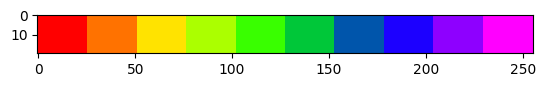

In [22]:
C = [
    '#ff0000',
    '#ff7200',
    '#ffe300',
    '#abff00',
    '#39ff00',
    '#00c739',
    '#0055ab',
    '#1c00ff',
    '#8e00ff',
    '#ff00ff',
]
import matplotlib as mpl # in python
cm = mpl.colors.ListedColormap(C)

gradient = np.linspace(0, 1, 256)
data = np.zeros((20, 256))
data[:, :] = gradient

plt.imshow(data, cmap=cm) # for example
plt.show()